<a href="https://colab.research.google.com/github/Dexter0013/Operations-on-Databases/blob/main/Image_Classification_and_store_into_local_database.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow #used for training the loaded model
!pip install pillow #used for image processing
!pip install numpy #scientific computation in python
!pip install keras #api for loading the model build on top of tensorflow
!pip install pandas #used for data manipulation and analysis
!pip install ipython-sql #used for mySQL database

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00


In [1]:
!mkdir data

In [2]:
# Import necessary libraries
import os  # For file system operations
import datetime  # To generate timestamp for saving files
import numpy as np  # For numerical operations
import csv #creating and accesssing csv files
from tensorflow.keras.preprocessing import image  # For image preprocessing
from tensorflow.keras.applications import EfficientNetB7  # Pretrained EfficientNetB7 model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions  # ImageNet utilities
# from PIL import Image  # For image processing
import matplotlib.pyplot as plt  # For plotting images
import pandas as pd
import sqlite3

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
[[('n03902125', 'pay-phone', np.float32(0.51265055)), ('n04335435', 'streetcar', np.float32(0.07836408)), ('n06794110', 'street_sign', np.float32(0.06160751)), ('n02747177', 'ashcan', np.float32(0.0288719)), ('n03891251', 'park_bench', np.float32(0.019393392))]]


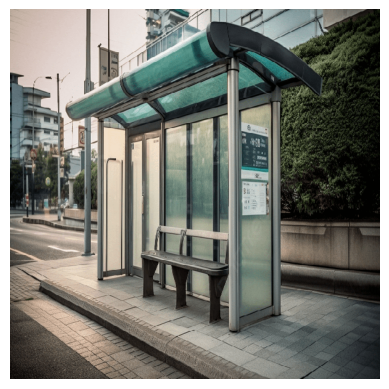

In [24]:
#Filename that conatins the image that will be used for prediction
f='data/bus stop.jpg'
#model contains the pre-trained model that where imageNet dataset is used
model = EfficientNetB7(weights='imagenet')
#Load the image with specific size 600x600 for EfficientNet(Model) to understand
img = image.load_img(f, target_size=(600, 600))  # EfficientNetB7 expects 600x600
#image us converted to an array using Keras api
img_array = image.img_to_array(img)
#Adding 4 th dimension to the img_array
img_array = np.expand_dims(img_array, axis=0)
#loading for identifying the image_arry
img_array = preprocess_input(img_array)
#predicting the image loaded
predictions = model.predict(img_array)
#getting the prediction result lalbels and score
results = decode_predictions(predictions)
#plotting the image
plt.imshow(img)
plt.axis('off')
#Displaying the result
print(results)

In [25]:
#input the prediction result, image_path, date and time stamps into a csv file
def append_prediction_to_csv(filename, prediction_results, image_path):
    # Check if the directory exists, create if not
    if not os.path.exists('data'):
        os.makedirs('data')

    # Define the full path to the CSV file within the 'data' directory
    csv_filepath = os.path.join('data', filename)

    # Define the header if the file is new
    header = ['ImageNet ID', 'Label', 'Score', 'date', 'time', 'Image_Path']

    # Check if the file exists to decide if we need to write the header
    file_exists = os.path.exists(csv_filepath)

    with open(csv_filepath, mode='a', newline='') as file:
        writer = csv.writer(file)

        # Write the header only if the file did not exist before
        if not file_exists:
            writer.writerow(header)

        # Get the current date and time
        now = datetime.datetime.now()
        current_date = now.strftime("%Y-%m-%d")
        current_time = now.strftime("%H:%M:%S")

        # Write each prediction result
        if prediction_results and prediction_results[0] and prediction_results[0][0]:
            # Extract the first prediction (ImageNet ID, Label, Score)
            first_prediction_row = prediction_results[0][0]
            # Ensure the data is a list of the three elements
            writer.writerow([first_prediction_row[0], first_prediction_row[1], first_prediction_row[2], current_date, current_time, image_path])

append_prediction_to_csv('prediction_results_imgPath.csv', results, f)

print(f"prediction_results_imagepath.csv",f)

prediction_results_imagepath.csv data/bus stop.jpg


In [26]:
#Read the file stored in a csv file using pandas DataFrame
res=pd.read_csv('/content/data/prediction_results_imgPath.csv')
res

,ImageNet ID,Label,Score,date,time,Image_Path
0,n03595614,jersey,0.223669,2025-07-06,14:25:27,data/women_football.jpg
1,n04146614,school_bus,0.826016,2025-07-06,14:26:47,data/Schoolbus.jpg
2,n02113023,Pembroke,0.889250,2025-07-06,14:28:12,data/dog.jpg
3,n03902125,pay-phone,0.512651,2025-07-06,14:30:01,data/bus stop.jpg


In [27]:
#Create a database prediction.db if not exists already
conn=sqlite3.connect('Prediction.db')

# Read the latest data from the CSV file
latest_res = pd.read_csv('/content/data/prediction_results_imgPath.csv')

# Read existing data from the database
# Using a try-except block in case the table doesn't exist yet
try:
    existing_data = pd.read_sql_query("SELECT Image_Path FROM prediction_results", conn)
    existing_image_paths = existing_data['Image_Path'].tolist()
except pd.io.sql.DatabaseError:
    # If the table doesn't exist, there are no existing image paths
    existing_image_paths = []


# Identify new rows in the CSV that are not in the database
new_rows = latest_res[~latest_res['Image_Path'].isin(existing_image_paths)]

# Insert only the new rows into the database
if not new_rows.empty:
    new_rows.to_sql("prediction_results", conn, if_exists="append", index=False)
    print(f"Inserted {len(new_rows)} new row(s) into the database.")
else:
    print("No new data to insert into the database.")

# You can optionally close the connection if you are done with database operations
# conn.close()

Inserted 1 new row(s) into the database.


In [28]:
#Query to check if the table exists in the database
df_check = pd.read_sql_query("SELECT * FROM prediction_results", conn)
conn.close()
df_check

,ImageNet ID,Label,Score,date,time,Image_Path
0,n03595614,jersey,0.223669,2025-07-06,14:25:27,data/women_football.jpg
1,n04146614,school_bus,0.826016,2025-07-06,14:26:47,data/Schoolbus.jpg
2,n02113023,Pembroke,0.889250,2025-07-06,14:28:12,data/dog.jpg
3,n03902125,pay-phone,0.512651,2025-07-06,14:30:01,data/bus stop.jpg


In [29]:
#Check the tables inserted in the database
df_check

,ImageNet ID,Label,Score,date,time,Image_Path
0,n03595614,jersey,0.223669,2025-07-06,14:25:27,data/women_football.jpg
1,n04146614,school_bus,0.826016,2025-07-06,14:26:47,data/Schoolbus.jpg
2,n02113023,Pembroke,0.889250,2025-07-06,14:28:12,data/dog.jpg
3,n03902125,pay-phone,0.512651,2025-07-06,14:30:01,data/bus stop.jpg


Displaying image: data/women_football.jpg


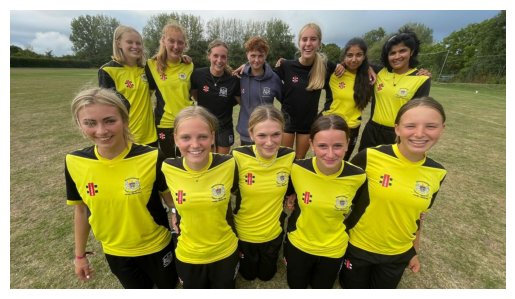

Displaying image: data/Schoolbus.jpg


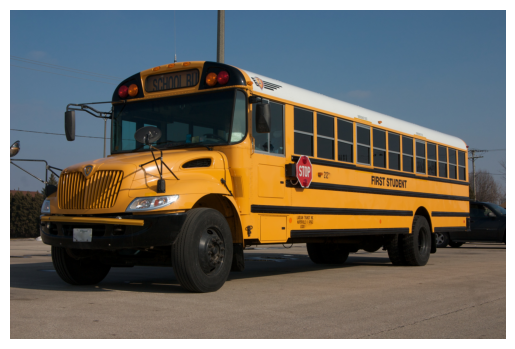

Displaying image: data/dog.jpg


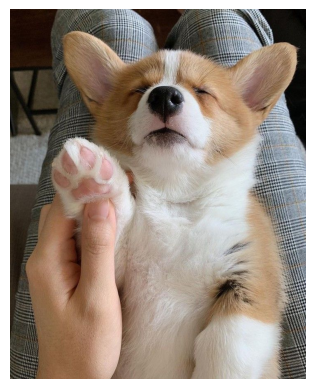

Displaying image: data/bus stop.jpg


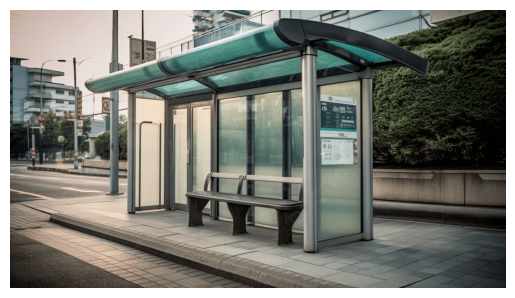

In [30]:
#iterate through the dataframe to display the image
for index, row in df_check.iterrows():
    image_path = row['Image_Path']
    print(f"Displaying image: {image_path}")
    try:
        img = image.load_img(image_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show() # Display the image
    except FileNotFoundError:
        print(f"Error: Image file not found at {image_path}")
    except Exception as e:
        print(f"Error loading or displaying image {image_path}: {e}")